In [56]:
import numpy as np
import matplotlib.pyplot as plt
from ypstruct import structure
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

data = fetch_california_housing()
X, y = data['data'][:500], data['target'][:500]

In [60]:
import numpy as np
from ypstruct import structure

#Run GA
def roulette_wheel_selection(p):
    c = np.cumsum(p)
    r = sum(p)*np.random.rand()
    ind = np.argwhere(r <= c)
    return ind[0][0]

def crossover(p1, p2, gamma=0.1):
    c1 = p1.deepcopy()
    c2 = p1.deepcopy()
    alpha = np.random.uniform(-gamma, 1+gamma, *c1.position.shape)
    c1.position = alpha*p1.position + (1-alpha)*p2.position
    c2.position = alpha*p2.position + (1-alpha)*p1.position
    return c1, c2


def mutate(x, mu, sigma):
    y = x.deepcopy()
    flag = np.random.rand(*x.position.shape) <= mu
    ind = np.argwhere(flag)
    y.position[ind] += sigma*np.random.randn(*ind.shape)
    return y
    
def apply_bound(x, varmin, varmax):
    x.position = np.maximum(x.position, varmin)
    x.position = np.minimum(x.position, varmax)
    
def run(problem, params, X, y):
    
    # Problem Information
    costfunc = problem.costfunc
    nvar = problem.nvar
    varmin = problem.varmin
    varmax = problem.varmax

    # Parameters
    maxit = params.maxit
    npop = params.npop
    beta = params.beta
    pc = params.pc
    nc = int(np.round(pc*npop/2)*2)
    gamma = params.gamma
    mu = params.mu
    sigma = params.sigma

    # Empty Individual Template
    empty_individual = structure()
    empty_individual.position = None
    empty_individual.cost = None

    # Best Solution Ever Found
    bestsol = empty_individual.deepcopy()
    bestsol.cost = 0
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    # Initialize Population
    pop = empty_individual.repeat(npop)
    for i in range(npop):
        pop[i].position = np.random.randint(varmin, varmax, nvar)

        rf = RandomForestRegressor(n_estimators=pop[i].position[0],
                                  max_depth=pop[i].position[1],
                                  min_samples_split=pop[i].position[2],
                                  min_samples_leaf=pop[i].position[3])
        
        rf.fit(X_train, y_train)
        y_hat = rf.predict(X_test)
        
        pop[i].cost = costfunc(y_hat, y_test)
        
        if pop[i].cost > bestsol.cost:
            bestsol = pop[i].deepcopy()

    # Best Cost of Iterations
    bestcost = np.empty(maxit)
    
    # Main Loop
    for it in range(maxit):

        costs = np.array([x.cost for x in pop])
        avg_cost = np.mean(costs)
        if avg_cost != 0:
            costs = costs/avg_cost
        probs = np.exp(-beta*costs)

        popc = []
        for _ in range(nc//2):

            # Select Parents
            #q = np.random.permutation(npop)
            #p1 = pop[q[0]]
            #p2 = pop[q[1]]

            # Perform Roulette Wheel Selection
            p1 = pop[roulette_wheel_selection(probs)]
            p2 = pop[roulette_wheel_selection(probs)]
            
            # Perform Crossover
            c1, c2 = crossover(p1, p2, gamma)

            # Perform Mutation
            c1 = mutate(c1, mu, sigma)
            c2 = mutate(c2, mu, sigma)

            # Apply Bounds
            apply_bound(c1, varmin, varmax)
            apply_bound(c2, varmin, varmax)

            # Evaluate First Offspring
            rf_1 = RandomForestRegressor(n_estimators=int(c1.position[0]),
                                  max_depth=int(c1.position[1]),
                                  min_samples_split=int(c1.position[2]),
                                  min_samples_leaf=int(c1.position[3]))
        
            rf_1.fit(X_train, y_train)
            y_hat_1 = rf_1.predict(X_test)
            
            c1.cost = costfunc(y_hat_1, y_test)
            if c1.cost > bestsol.cost:
                bestsol = c1.deepcopy()

            # Evaluate Second Offspring
            rf_2 = RandomForestRegressor(n_estimators=int(c2.position[0]),
                                  max_depth=int(c2.position[1]),
                                  min_samples_split=int(c2.position[2]),
                                  min_samples_leaf=int(c2.position[3]))
        
            rf_2.fit(X_train, y_train)
            y_hat_2 = rf_2.predict(X_test)

            c2.cost = costfunc(y_hat_2, y_test)
            if c2.cost > bestsol.cost:
                bestsol = c2.deepcopy()

            # Add Offsprings to popc
            popc.append(c1)
            popc.append(c2)
        

        # Merge, Sort and Select
        pop += popc
        pop = sorted(pop, key=lambda x: x.cost, reverse=True)
        pop = pop[0:npop]

        # Store Best Cost
        bestcost[it] = bestsol.cost

        # Show Iteration Information
        print("Iteration {}: Best Cost = {}".format(it, bestcost[it]))

    # Output
    out = structure()
    out.pop = pop
    out.bestsol = bestsol
    out.bestcost = bestcost
    return out

Iteration 0: Best Cost = 0.859615652395112
Iteration 1: Best Cost = 0.8620666559033434
Iteration 2: Best Cost = 0.8620666559033434
Iteration 3: Best Cost = 0.8638176998362839
Iteration 4: Best Cost = 0.8706720517949322
Iteration 5: Best Cost = 0.8706720517949322
Iteration 6: Best Cost = 0.8706720517949322
Iteration 7: Best Cost = 0.8706720517949322
Iteration 8: Best Cost = 0.8706720517949322
Iteration 9: Best Cost = 0.8706720517949322
Iteration 10: Best Cost = 0.8706720517949322
Iteration 11: Best Cost = 0.873828821109697
Iteration 12: Best Cost = 0.873828821109697
Iteration 13: Best Cost = 0.873828821109697
Iteration 14: Best Cost = 0.873828821109697
Iteration 15: Best Cost = 0.873828821109697
Iteration 16: Best Cost = 0.873828821109697
Iteration 17: Best Cost = 0.873828821109697
Iteration 18: Best Cost = 0.873828821109697
Iteration 19: Best Cost = 0.873828821109697
Iteration 20: Best Cost = 0.873828821109697
Iteration 21: Best Cost = 0.873828821109697
Iteration 22: Best Cost = 0.8738

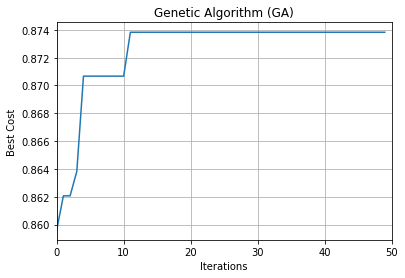

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from ypstruct import structure

# Sphere Test Function
def prec(y_hat, y_real):
    return r2_score(y_hat, y_real)

# Problem Definition
problem = structure()
problem.costfunc = prec
problem.nvar = 4
#n_estimators, max_depth, min samples split, min samples leaf
problem.varmin = [1, 1, 2, 1]
problem.varmax = [100,  50, 20, 20]

# GA Parameters
params = structure()
params.maxit = 50
params.npop = 50
params.beta = 1
params.pc = 1
params.gamma = 0.1
params.mu = 0.01
params.sigma = 0.1

# Run GA
out = run(problem, params, X, y)

# Results
plt.plot(out.bestcost)
# plt.semilogy(out.bestcost)
plt.xlim(0, params.maxit)
plt.xlabel('Iterations')
plt.ylabel('Best Cost')
plt.title('Genetic Algorithm (GA)')
plt.grid(True)
plt.show()

In [62]:
out.pop

[structure({'position': array([61.32324427, 33.07425141,  3.24502693,  1.18306093]), 'cost': 0.873828821109697}),
 structure({'position': array([43.01090457, 36.52439672,  4.33104759,  1.60568717]), 'cost': 0.8737101340843463}),
 structure({'position': array([61.16198671, 34.55204902,  4.70788294,  1.63905634]), 'cost': 0.8736727033979828}),
 structure({'position': array([47.50100337, 34.86902926,  4.03040039,  1.70198117]), 'cost': 0.8728286403567203}),
 structure({'position': array([45.53790211, 26.68935032,  4.6279227 ,  1.70628167]), 'cost': 0.8726333291160824}),
 structure({'position': array([55.57366455, 33.45807946,  3.11505316,  1.28001246]), 'cost': 0.8714103491728398}),
 structure({'position': array([63.098203  , 32.896539  ,  5.9740834 ,  1.32760318]), 'cost': 0.8712642550295322}),
 structure({'position': array([63.45162473, 28.29341278,  4.32937235,  1.28682829]), 'cost': 0.8712577715305483}),
 structure({'position': array([62.76441714, 32.2527019 ,  4.84802548,  1.51292738

In [49]:
rf = RandomForestRegressor()
rf.fit(X, y)
y_hat = rf.predict(X)